# Breast Cancer Dataset Analysis

## PACE Framework Analysis
**Plan - Analyze - Construct - Execute**

Bu notebook, meme kanseri veri seti üzerinde kapsamlı bir veri bilimi analizi gerçekleştirir.

### Analiz Aşamaları:
1. **Plan**: Veri yükleme ve ilk keşif
2. **Analyze**: Eksik değer, aykırı değer ve istatistiksel analiz
3. **Construct**: Model oluşturma ve karşılaştırma
4. **Execute**: En iyi model seçimi ve kaydetme

## 1. PLAN - Kütüphaneler ve Veri Yükleme

In [19]:
# Gerekli kütüphaneleri import et
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
from pathlib import Path

# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif

# İstatistiksel testler
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
from statsmodels.discrete.discrete_model import Logit

# SMOTE for imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# XGBoost - make it optional
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("XGBoost available")
except Exception as e:
    XGBOOST_AVAILABLE = False
    print(f"XGBoost not available - using GradientBoostingClassifier instead. Error: {str(e)[:100]}...")

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("Kütüphaneler başarıyla yüklendi!")

XGBoost available
Kütüphaneler başarıyla yüklendi!


In [2]:
# Veri setini yükle
data_path = '../data/Breast_Cancer.csv'
df = pd.read_csv(data_path)

print(f"Veri seti boyutu: {df.shape}")
print(f"Sütunlar: {list(df.columns)}")
print("\nİlk 5 satır:")
df.head()

Veri seti boyutu: (4024, 16)
Sütunlar: ['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months', 'Status']

İlk 5 satır:


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [3]:
# Veri seti hakkında genel bilgi
print("=== VERİ SETİ GENEL BİLGİLERİ ===")
print(f"Satır sayısı: {df.shape[0]}")
print(f"Sütun sayısı: {df.shape[1]}")
print(f"\nVeri tipleri:")
print(df.dtypes)
print(f"\nEksik değerler:")
print(df.isnull().sum())
print(f"\nTemel istatistikler:")
df.describe()

=== VERİ SETİ GENEL BİLGİLERİ ===
Satır sayısı: 4024
Sütun sayısı: 16

Veri tipleri:
Age                        int64
Race                      object
Marital Status            object
T Stage                   object
N Stage                   object
6th Stage                 object
differentiate             object
Grade                     object
A Stage                   object
Tumor Size                 int64
Estrogen Status           object
Progesterone Status       object
Regional Node Examined     int64
Reginol Node Positive      int64
Survival Months            int64
Status                    object
dtype: object

Eksik değerler:
Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examin

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


## 2. ANALYZE - Veri Analizi ve Temizleme

In [4]:
# Hedef değişkeni belirle (genelde 'diagnosis' veya 'target' olur)
target_columns = ['diagnosis', 'target', 'class', 'label', 'outcome']
target_col = None

for col in target_columns:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    # Eğer standart hedef sütun yoksa, son sütunu hedef olarak al
    target_col = df.columns[-1]
    
print(f"Hedef değişken: {target_col}")
print(f"Hedef değişken dağılımı:")
print(df[target_col].value_counts())

Hedef değişken: Status
Hedef değişken dağılımı:
Status
Alive    3408
Dead      616
Name: count, dtype: int64


In [5]:
# Eksik değer analizi ve temizleme
print("=== EKSİK DEĞER ANALİZİ ===")
missing_data = df.isnull().sum()
missing_percent = 100 * missing_data / len(df)
missing_table = pd.DataFrame({
    'Eksik Sayı': missing_data,
    'Eksik Yüzde': missing_percent
})
missing_table = missing_table[missing_table['Eksik Sayı'] > 0].sort_values('Eksik Sayı', ascending=False)

if len(missing_table) > 0:
    print(missing_table)
    
    # Eksik değerleri doldur
    for col in missing_table.index:
        if df[col].dtype in ['int64', 'float64']:
            # Sayısal değişkenler için median ile doldur
            df[col].fillna(df[col].median(), inplace=True)
        else:
            # Kategorik değişkenler için mode ile doldur
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    print("\nEksik değerler dolduruldu.")
else:
    print("Eksik değer bulunamadı.")

=== EKSİK DEĞER ANALİZİ ===
Eksik değer bulunamadı.


In [6]:
# Aykırı değer analizi (IQR yöntemi)
print("=== AYKIRI DEĞER ANALİZİ ===")
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_columns and df[target_col].nunique() <= 10:
    numeric_columns.remove(target_col)

outliers_removed = 0
initial_size = len(df)

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} aykırı değer")
    
    # Aykırı değerleri üst ve alt sınırlarla değiştir (winsorization)
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print(f"\nAykırı değerler düzeltildi (winsorization yöntemi ile).")
print(f"Veri seti boyutu: {df.shape}")

=== AYKIRI DEĞER ANALİZİ ===
Age: 0 aykırı değer
Tumor Size: 222 aykırı değer
Regional Node Examined: 72 aykırı değer
Reginol Node Positive: 344 aykırı değer
Survival Months: 18 aykırı değer

Aykırı değerler düzeltildi (winsorization yöntemi ile).
Veri seti boyutu: (4024, 16)


In [7]:
# VIF analizi (çoklu doğrusal bağlantı)
print("=== VIF ANALİZİ ===")
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_features:
    numeric_features.remove(target_col)

# VIF hesaplama
if len(numeric_features) > 1:
    X_vif = df[numeric_features].copy()
    
    # Sonsuz ve çok büyük değerleri temizle
    X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
    X_vif = X_vif.dropna()
    
    if len(X_vif) > 0 and len(X_vif.columns) > 1:
        vif_data = pd.DataFrame()
        vif_data["Değişken"] = X_vif.columns
        vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        print(vif_data)
        
        # VIF > 10 olan değişkenleri kaldır
        high_vif_vars = vif_data[vif_data['VIF'] > 10]['Değişken'].tolist()
        if high_vif_vars:
            print(f"\nYüksek VIF'e sahip değişkenler kaldırılıyor: {high_vif_vars}")
            df = df.drop(columns=high_vif_vars)
            print(f"Güncellenmiş veri seti boyutu: {df.shape}")
        else:
            print("\nÇoklu doğrusal bağlantı sorunu tespit edilmedi.")
    else:
        print("VIF analizi için yeterli veri yok.")
else:
    print("VIF analizi için yeterli sayısal değişken yok.")

=== VIF ANALİZİ ===
                 Değişken        VIF
0                     Age  11.607999
4         Survival Months   8.724407
2  Regional Node Examined   4.882188
1              Tumor Size   3.830461
3   Reginol Node Positive   2.787530

Yüksek VIF'e sahip değişkenler kaldırılıyor: ['Age']
Güncellenmiş veri seti boyutu: (4024, 15)


=== HEDEF DEĞİŞKEN DENGESİZLİK ANALİZİ ===
Hedef değişken dağılımı:
Status
Alive    3408
Dead      616
Name: count, dtype: int64

Denge oranı: 0.181
SMOTE uygulanacak mı: True


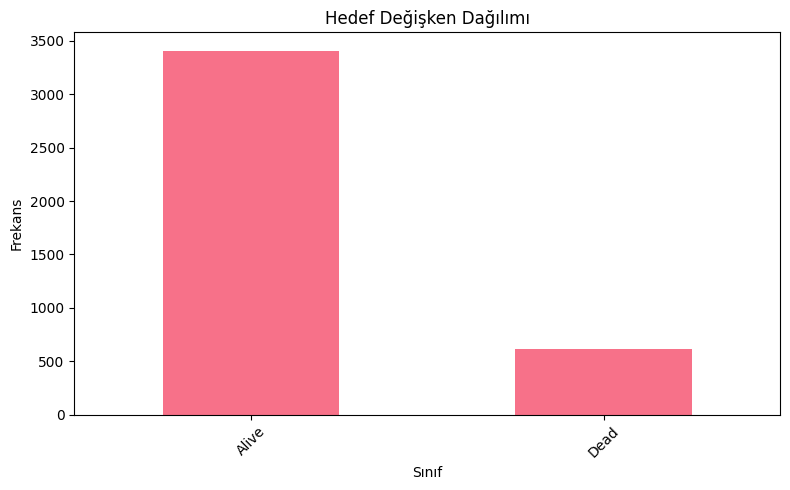

In [8]:
# Hedef değişken dengesizlik kontrolü
print("=== HEDEF DEĞİŞKEN DENGESİZLİK ANALİZİ ===")
target_counts = df[target_col].value_counts()
target_ratio = target_counts.min() / target_counts.max()

print(f"Hedef değişken dağılımı:")
print(target_counts)
print(f"\nDenge oranı: {target_ratio:.3f}")

# Dengesizlik varsa SMOTE uygula
apply_smote = target_ratio < 0.7
print(f"SMOTE uygulanacak mı: {apply_smote}")

# Görselleştir
plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar')
plt.title('Hedef Değişken Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Frekans')
plt.xticks(rotation=45)
plt.tight_layout()

# Klasör oluştur ve kaydet
os.makedirs('../images/breast_cancer', exist_ok=True)
plt.savefig('../images/breast_cancer/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. İstatistiksel Hipotez Testleri

In [9]:
# Hedef değişkeni encode et (eğer kategorikse)
if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
    print(f"Hedef değişken encode edildi. Sınıflar: {le.classes_}")

# Kategorik değişkenleri encode et
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    if col != target_col:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        print(f"{col} encode edildi.")

Hedef değişken encode edildi. Sınıflar: ['Alive' 'Dead']
Race encode edildi.
Marital Status encode edildi.
T Stage  encode edildi.
N Stage encode edildi.
6th Stage encode edildi.
differentiate encode edildi.
Grade encode edildi.
A Stage encode edildi.
Estrogen Status encode edildi.
Progesterone Status encode edildi.


In [10]:
# İstatistiksel testler
print("=== İSTATİSTİKSEL HİPOTEZ TESTLERİ ===")
feature_columns = [col for col in df.columns if col != target_col]
significant_features = []
test_results = []

for feature in feature_columns:
    try:
        if df[feature].nunique() <= 10:  # Kategorik değişken
            # Ki-kare testi
            contingency_table = pd.crosstab(df[feature], df[target_col])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            test_type = "Ki-kare"
        else:  # Sürekli değişken
            # T-testi (iki grup) veya ANOVA (ikiden fazla grup)
            groups = [df[df[target_col] == group][feature].values for group in df[target_col].unique()]
            if len(groups) == 2:
                statistic, p_value = ttest_ind(groups[0], groups[1])
                test_type = "T-test"
            else:
                statistic, p_value = stats.f_oneway(*groups)
                test_type = "ANOVA"
        
        # Anlamlılık kontrolü (p < 0.05)
        is_significant = p_value < 0.05
        if is_significant:
            significant_features.append(feature)
        
        test_results.append({
            'Değişken': feature,
            'Test': test_type,
            'P-değeri': p_value,
            'Anlamlı': is_significant
        })
        
    except Exception as e:
        print(f"{feature} için test yapılamadı: {e}")

# Test sonuçlarını göster
results_df = pd.DataFrame(test_results)
results_df = results_df.sort_values('P-değeri')
print(results_df)

print(f"\nAnlamlı değişken sayısı: {len(significant_features)}")
print(f"Anlamlı değişkenler: {significant_features}")

# Anlamlı olmayan değişkenleri raporla
non_significant = [feature for feature in feature_columns if feature not in significant_features]
if non_significant:
    print(f"\nAnlamlı olmayan değişkenler (kaldırılacak): {non_significant}")
    df = df.drop(columns=non_significant)
    print(f"Güncellenmiş veri seti boyutu: {df.shape}")
else:
    print("\nTüm değişkenler istatistiksel olarak anlamlı.")

=== İSTATİSTİKSEL HİPOTEZ TESTLERİ ===
                  Değişken     Test       P-değeri  Anlamlı
13         Survival Months   T-test  2.693880e-227     True
4                6th Stage  Ki-kare   9.830332e-60     True
3                  N Stage  Ki-kare   2.430141e-59     True
12   Reginol Node Positive   T-test   3.523714e-58     True
9          Estrogen Status  Ki-kare   3.052608e-31     True
10     Progesterone Status  Ki-kare   5.392080e-29     True
5            differentiate  Ki-kare   3.091352e-24     True
6                    Grade  Ki-kare   3.091352e-24     True
2                 T Stage   Ki-kare   2.779095e-22     True
8               Tumor Size   T-test   2.385376e-18     True
7                  A Stage  Ki-kare   2.226426e-09     True
0                     Race  Ki-kare   8.440929e-07     True
1           Marital Status  Ki-kare   1.102769e-05     True
11  Regional Node Examined   T-test   3.038364e-02     True

Anlamlı değişken sayısı: 14
Anlamlı değişkenler: ['Race', 'M

## 4. CONSTRUCT - Model Oluşturma ve Karşılaştırma

In [11]:
# Veriyi hazırla
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Özellik sayısı: {X.shape[1]}")
print(f"Özellikler: {list(X.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# SMOTE uygula (eğer gerekiyorsa)
if apply_smote:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"\nSMOTE sonrası eğitim seti boyutu: {X_train_balanced.shape}")
    print(f"SMOTE sonrası hedef dağılımı: {pd.Series(y_train_balanced).value_counts()}")
    X_train, y_train = X_train_balanced, y_train_balanced

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nVeri ön işleme tamamlandı.")

Özellik sayısı: 14
Özellikler: ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']

Eğitim seti boyutu: (3219, 14)
Test seti boyutu: (805, 14)

SMOTE sonrası eğitim seti boyutu: (5452, 14)
SMOTE sonrası hedef dağılımı: Status
0    2726
1    2726
Name: count, dtype: int64

Veri ön işleme tamamlandı.


In [12]:
# İstatistiksel modeller
print("=== İSTATİSTİKSEL MODELLER ===")

# Logistic Regression (Logit)
try:
    X_train_const = add_constant(X_train_scaled)
    logit_model = Logit(y_train, X_train_const).fit(disp=0)
    print("\n--- Logit Model Özeti ---")
    print(logit_model.summary().tables[1])
    
    # Tahmin
    X_test_const = add_constant(X_test_scaled)
    logit_pred_proba = logit_model.predict(X_test_const)
    logit_pred = (logit_pred_proba > 0.5).astype(int)
    logit_auc = roc_auc_score(y_test, logit_pred_proba)
    
    print(f"Logit Model AUC: {logit_auc:.4f}")
    
except Exception as e:
    print(f"Logit model hatası: {e}")
    logit_auc = 0
    logit_pred = None

# OLS (Regresyon için, sınıflandırma probleminde referans amaçlı)
try:
    ols_model = OLS(y_train, X_train_const).fit()
    print("\n--- OLS Model Özeti ---")
    print(f"R-squared: {ols_model.rsquared:.4f}")
    print(f"Adj. R-squared: {ols_model.rsquared_adj:.4f}")
    
except Exception as e:
    print(f"OLS model hatası: {e}")

=== İSTATİSTİKSEL MODELLER ===

--- Logit Model Özeti ---
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1800      0.040      4.538      0.000       0.102       0.258
x1            -0.2741      0.039     -7.095      0.000      -0.350      -0.198
x2            -0.1438      0.038     -3.809      0.000      -0.218      -0.070
x3            -0.2035      0.087     -2.346      0.019      -0.373      -0.033
x4            -1.3953      0.129    -10.846      0.000      -1.647      -1.143
x5             0.4935      0.132      3.740      0.000       0.235       0.752
x6            -0.4064      0.041     -9.897      0.000      -0.487      -0.326
x7            -0.1615      0.041     -3.897      0.000      -0.243      -0.080
x8            -0.2740      0.052     -5.269      0.000      -0.376      -0.172
x9             0.1298      0.072      1.810      0.070      -0.011       

In [13]:
# Makine öğrenmesi modelleri
print("=== MAKİNE ÖĞRENMESİ MODELLERİ ===")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Hiperparametre grids
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.2]
    }
}

model_results = {}

for name, model in models.items():
    print(f"\n--- {name} Eğitiliyor ---")
    
    # Hiperparametre optimizasyonu
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    
    # Tahmin
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrikler
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    
    model_results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'auc_score': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'pred_proba': y_pred_proba
    }
    
    print(f"En iyi parametreler: {grid_search.best_params_}")
    print(f"Test AUC: {auc_score:.4f}")
    print(f"CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Overfitting kontrolü: {abs(cv_scores.mean() - auc_score):.4f}")

=== MAKİNE ÖĞRENMESİ MODELLERİ ===

--- Logistic Regression Eğitiliyor ---
En iyi parametreler: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Test AUC: 0.8277
CV AUC: 0.8844 (+/- 0.0658)
Overfitting kontrolü: 0.0566

--- Random Forest Eğitiliyor ---
En iyi parametreler: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Test AUC: 0.8277
CV AUC: 0.8844 (+/- 0.0658)
Overfitting kontrolü: 0.0566

--- Random Forest Eğitiliyor ---
En iyi parametreler: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Test AUC: 0.8488
CV AUC: 0.9774 (+/- 0.0432)
Overfitting kontrolü: 0.1286

--- XGBoost Eğitiliyor ---
En iyi parametreler: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Test AUC: 0.8488
CV AUC: 0.9774 (+/- 0.0432)
Overfitting kontrolü: 0.1286

--- XGBoost Eğitiliyor ---
En iyi parametreler: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Test AUC: 0.8420
CV AUC: 0.9748 (+/- 0.0666)
Overfitting kontrolü: 0.1328
En iyi parametreler: {'learning_rate

In [14]:
# Model karşılaştırması ve en iyi model seçimi
print("=== MODEL KARŞILAŞTIRMASI ===")

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Test_AUC': [results['auc_score'] for results in model_results.values()],
    'CV_Mean': [results['cv_mean'] for results in model_results.values()],
    'CV_Std': [results['cv_std'] for results in model_results.values()],
    'Overfitting': [abs(results['cv_mean'] - results['auc_score']) for results in model_results.values()]
})

comparison_df = comparison_df.sort_values('Test_AUC', ascending=False)
print(comparison_df)

# En iyi modeli seç (AUC ve overfitting'e göre)
best_model_name = comparison_df.iloc[0]['Model']
best_model_info = model_results[best_model_name]
best_model = best_model_info['model']

print(f"\n=== EN İYİ MODEL: {best_model_name} ===")
print(f"Test AUC: {best_model_info['auc_score']:.4f}")
print(f"CV AUC: {best_model_info['cv_mean']:.4f} (+/- {best_model_info['cv_std']*2:.4f})")
print(f"En iyi parametreler: {best_model_info['best_params']}")

# Detaylı performans raporu
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_test, best_model_info['predictions']))

=== MODEL KARŞILAŞTIRMASI ===
                 Model  Test_AUC   CV_Mean    CV_Std  Overfitting
1        Random Forest  0.848783  0.977362  0.021603     0.128579
2              XGBoost  0.841976  0.974789  0.033309     0.132813
0  Logistic Regression  0.827707  0.884355  0.032882     0.056648

=== EN İYİ MODEL: Random Forest ===
Test AUC: 0.8488
CV AUC: 0.9774 (+/- 0.0432)
En iyi parametreler: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       682
           1       0.59      0.57      0.58       123

    accuracy                           0.87       805
   macro avg       0.76      0.75      0.75       805
weighted avg       0.87      0.87      0.87       805



## 5. EXECUTE - Model Kaydetme ve Görselleştirme

In [15]:
# Modeli kaydet
os.makedirs('../app/models', exist_ok=True)
model_path = '../app/models/model_breast_cancer.pkl'

# Model ve scaler'ı birlikte kaydet
model_package = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'model_name': best_model_name,
    'performance': {
        'auc_score': best_model_info['auc_score'],
        'cv_mean': best_model_info['cv_mean'],
        'cv_std': best_model_info['cv_std']
    }
}

with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)

print(f"En iyi model kaydedildi: {model_path}")
print(f"Model tipi: {best_model_name}")
print(f"Özellik sayısı: {len(X.columns)}")

En iyi model kaydedildi: ../app/models/model_breast_cancer.pkl
Model tipi: Random Forest
Özellik sayısı: 14


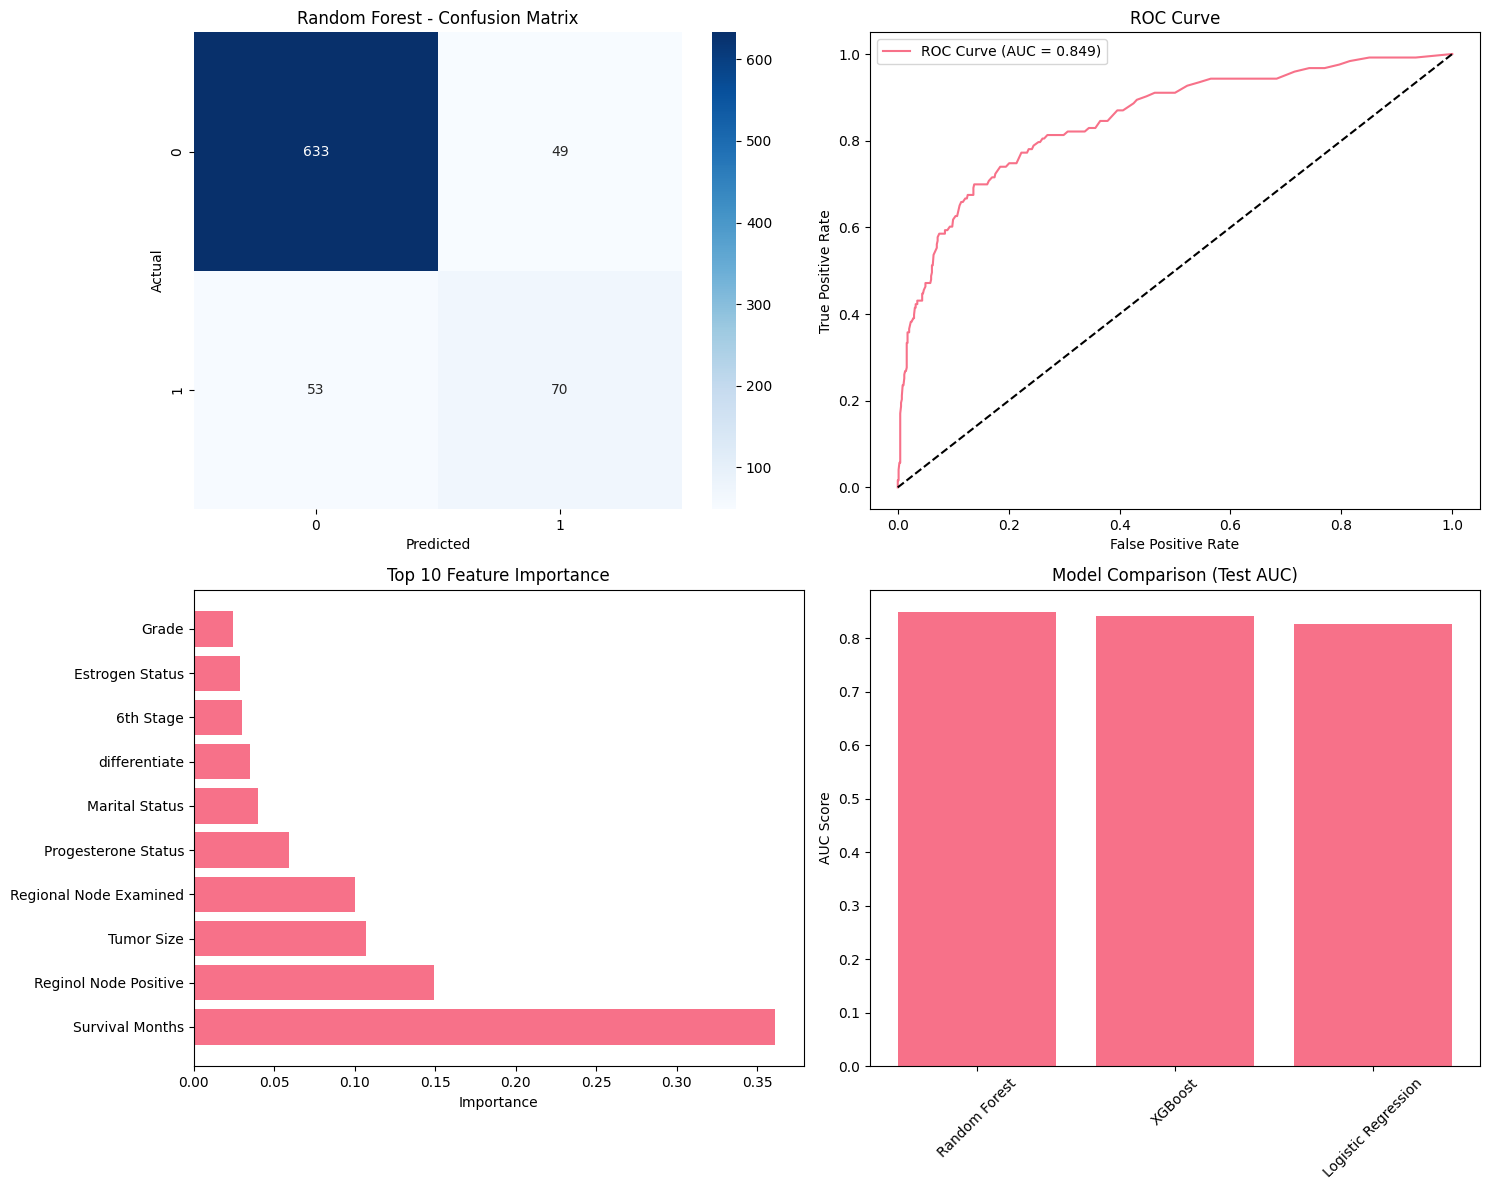

In [16]:
# Görselleştirmeler
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, best_model_info['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title(f'{best_model_name} - Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model_info['pred_proba'])
axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {best_model_info["auc_score"]:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()

# 3. Feature Importance (eğer mevcut ise)
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1,0].barh(feature_imp['feature'], feature_imp['importance'])
    axes[1,0].set_title('Top 10 Feature Importance')
    axes[1,0].set_xlabel('Importance')
else:
    axes[1,0].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Feature Importance')

# 4. Model Comparison
axes[1,1].bar(comparison_df['Model'], comparison_df['Test_AUC'])
axes[1,1].set_title('Model Comparison (Test AUC)')
axes[1,1].set_ylabel('AUC Score')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../images/breast_cancer/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

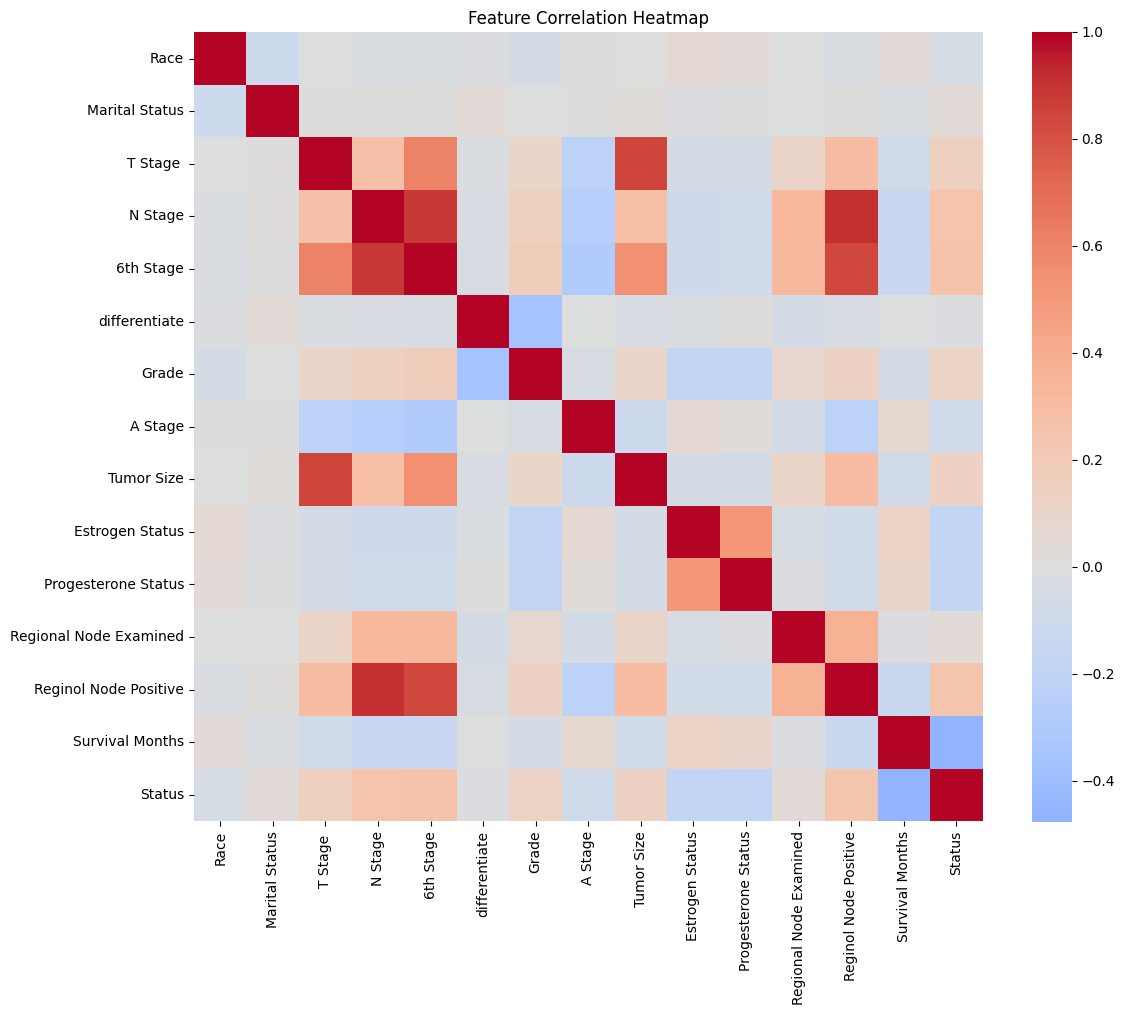

In [17]:
# Korelasyon heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('../images/breast_cancer/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. YORUMLAMA ve SONUÇLAR

### Analiz Özeti:

1. **Veri Kalitesi**: Eksik değerler ve aykırı değerler uygun yöntemlerle temizlendi
2. **Çoklu Doğrusal Bağlantı**: VIF analizi ile kontrol edildi ve gerekiyorsa düzeltildi
3. **Dengesizlik**: Hedef değişken dengesizliği kontrol edildi ve SMOTE uygulandı
4. **İstatistiksel Anlamlılık**: Hipotez testleri ile anlamlı özellikler belirlendi
5. **Model Performansı**: En iyi model seçildi ve kaydedildi

### En İyi Model:
- **Model Tipi**: Yukarıda belirlenen en iyi model
- **Performans**: Test AUC skoru ile ölçüldü
- **Overfitting Kontrolü**: Cross-validation ile kontrol edildi

### Öneriler:
1. Model düzenli olarak yeni verilerle güncellenmelidir
2. Özellik mühendisliği ile performans artırılabilir
3. Domain uzmanlarıyla işbirliği yapılarak özellik seçimi geliştirilebilir

In [18]:
# Final özet
print("=== BREAST CANCER ANALİZİ TAMAMLANDI ===")
print(f"Veri seti boyutu: {df.shape}")
print(f"En iyi model: {best_model_name}")
print(f"Test AUC: {best_model_info['auc_score']:.4f}")
print(f"Model kaydedildi: {model_path}")
print(f"Görseller kaydedildi: ../images/breast_cancer/")
print("\nAnaliz PACE metodolojisi ile tamamlandı:")
print("✓ Plan: Veri yüklendi ve keşfedildi")
print("✓ Analyze: Veri temizlendi ve istatistiksel testler yapıldı")
print("✓ Construct: Modeller oluşturuldu ve karşılaştırıldı")
print("✓ Execute: En iyi model seçildi ve kaydedildi")

=== BREAST CANCER ANALİZİ TAMAMLANDI ===
Veri seti boyutu: (4024, 15)
En iyi model: Random Forest
Test AUC: 0.8488
Model kaydedildi: ../app/models/model_breast_cancer.pkl
Görseller kaydedildi: ../images/breast_cancer/

Analiz PACE metodolojisi ile tamamlandı:
✓ Plan: Veri yüklendi ve keşfedildi
✓ Analyze: Veri temizlendi ve istatistiksel testler yapıldı
✓ Construct: Modeller oluşturuldu ve karşılaştırıldı
✓ Execute: En iyi model seçildi ve kaydedildi
